# BERT Model
Some code was adapted from Coursera guided project Sentiment Analysis with BERT

Best if run in Colab using GPU

## Step 1: Load the Data

In [ ]:
%%capture
!pip install transformers

In [ ]:
import torch
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
import plotly.graph_objects as go

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/STATS402_Project/hateful_memes/"

In [ ]:
import pandas as pd
test_data = pd.read_json(path+'dev_seen.jsonl',lines=True)
dev_unseen_data= pd.read_json(path+'dev_unseen.jsonl',lines=True)
final_test_data=pd.read_json(path+'test_seen.jsonl',lines=True)
test_unseen_data=pd.read_json(path+'test_unseen.jsonl',lines=True)
train_data=pd.read_json(path+'train.jsonl',lines=True)
test_data.head()

,id,img,label,text
0,8291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime


## Step 2: Loading Tokenizer and Encoding our Data

In [ ]:
# Create the tokenizer
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tokenizer.tokenize('Adorable African Kid Appreciating life ')

['adorable', 'african', 'kid', 'app', '##re', '##cia', '##ting', 'life']

In [ ]:
tokenizer('Adorable African Kid Appreciating life')

{'input_ids': [101, 23677, 3060, 4845, 10439, 2890, 7405, 3436, 2166, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.decode(tokenizer('Adorable African Kid Appreciating life')['input_ids'])

'[CLS] adorable african kid appreciating life [SEP]'

In [ ]:
# Adapted from Coursera guided project "Sentiment Analysis with BERT"
encoded_data_train = tokenizer.batch_encode_plus(
    train_data.text.values,
    add_special_tokens=True, # set this so BERT knows when a sentence ends and begins
    return_attention_mask=True, #using a fixed input, all sentences have same dimensionality. Tells us where actual values are and where zeros are
    padding = True, # make sure to pad sentences so they are all the same length
    max_length = 256, # this is the length we want all senteces to be
    return_tensors = 'pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    test_data.text.values,
    add_special_tokens=True, # set this so BERT knows when a sentence ends and begins
    return_attention_mask=True, #using a fixed input, all sentences have same dimensionality. Tells us where actual values are and where zeros are
    padding = True, # make sure to pad sentences so they are all the same length
    max_length = 256, # this is the length we want all senteces to be
    return_tensors = 'pt'
)

encoded_final_test= tokenizer.batch_encode_plus(
    final_test_data.text.values,
    add_special_tokens=True, # set this so BERT knows when a sentence ends and begins
    return_attention_mask=True, #using a fixed input, all sentences have same dimensionality. Tells us where actual values are and where zeros are
    padding = True, # make sure to pad sentences so they are all the same length
    max_length = 256, # this is the length we want all senteces to be
    return_tensors = 'pt'
)

# get the parts from the encoding that need to train the model
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_data.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(test_data.label.values)

input_ids_final_test = encoded_final_test['input_ids']
attention_masks_final_test = encoded_final_test['attention_mask']
labels_final_test = torch.tensor(final_test_data.label.values)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2268: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_final_test = TensorDataset(input_ids_final_test, attention_masks_final_test, labels_final_test)

In [ ]:
print(len(dataset_train))
print(len(dataset_val))
print(len(dataset_final_test))

8500
500
1000


## Step 3: Setting up BERT Pretrained Model

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    num_labels=len(train_data.label.unique()),
    output_attentions=False,
    output_hidden_states=False
)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Step 4: Creating Data Loaders

In [ ]:
# Adapted from Coursera guided project "Sentiment Analysis with BERT"
batch_size=32

dataloader_train=DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val=DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=32
)

dataloader_final_test = DataLoader(
    dataset_final_test,
    batch_size=32
)

## Step 5: Setting Up Optimizer and Scheduler

In [ ]:
# Adam is a stochastic optimization
optimizer = AdamW(
    model.parameters(),
    lr= 1e-5, #2e-5 > 5e -5
    eps=1e-8
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
epochs = 30

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) *epochs
)

## Step 6: Defining our Performance Metric

In [ ]:
def auc(preds, labels):
    preds_flat=np.argmax(preds, axis=1).flatten()
    labels_flat=labels.flatten()
    return roc_auc_score(labels_flat, preds_flat)

## Step 7: Creating our Training Loop

Approach adapted from an older version of HuggingFace's `run_glue.py` script. Accessible [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

In [ ]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val) #usually if using GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [ ]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals


In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    model.train() # put model in training mode
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch), 
                       leave = False,
                       disable = False)
    for batch in progress_bar:
        
        model.zero_grad() # set the gradient to zero
        
        batch = tuple(b.to(device) for b in batch) # make sure each item on device
        
        # get the inputs to the model
        inputs = {
            'input_ids': batch[0],
            'attention_mask' : batch[1],
            'labels': batch[2]
        }
    
        # get the outputs
        outputs = model(**inputs)
        
        #BERT returns loss and logits
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward() # backpropagation
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # prevents gradient from getting too small or too big
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
    torch.save(model.state_dict(), f'/content/drive/MyDrive/STATS402_Project/hateful_memes/models/BERT2_ft_epoch{epoch}.model')
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_value = evaluate(dataloader_val)
    val_AUC = auc(predictions, true_value)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'AUC Score: {val_AUC}')

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/266 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## Step 8: Loading and Evaluating our Model

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(train_data.label.unique()),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model.to(device)
pass

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# load a pretrained model
model.load_state_dict(
    torch.load('/content/drive/MyDrive/STATS402_Project/hateful_memes/models/BERT2_ft_epoch22.model',
    map_location = torch.device('cpu'))
)

<All keys matched successfully>

In [ ]:
# Get the predictions for the hold out test set
_, predictions, true_vals = evaluate(dataloader_final_test)

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
# Get the predictions for the training set
_, train_predictions, train_true_vals = evaluate(dataloader_train)

  0%|          | 0/266 [00:00<?, ?it/s]

In [ ]:
from sklearn import metrics
#print(metrics.classification_report(predictions, true_vals))
pred = predictions[:,1] 
pred = np.where(pred > 0, pred, 0)
pred = np.where(pred <= 0, pred, 1)

pred
print(metrics.classification_report(pred, true_vals))

              precision    recall  f1-score   support

         0.0       0.81      0.56      0.66       728
         1.0       0.35      0.64      0.45       272

    accuracy                           0.58      1000
   macro avg       0.58      0.60      0.56      1000
weighted avg       0.68      0.58      0.61      1000



In [ ]:
# Get the AUC on the hold out test set
final_test_auc = auc(predictions, true_vals)
train_auc = auc(train_predictions, train_true_vals)
print(final_test_auc)
print(train_auc)

0.5784113645458183
0.9254842483646267


In [ ]:
!pip install -q plotly==5.0.0

     |████████████████████████████████| 19.1 MB 9.3 MB/s 


In [ ]:
#import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py

In [ ]:
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'ROC Curve')

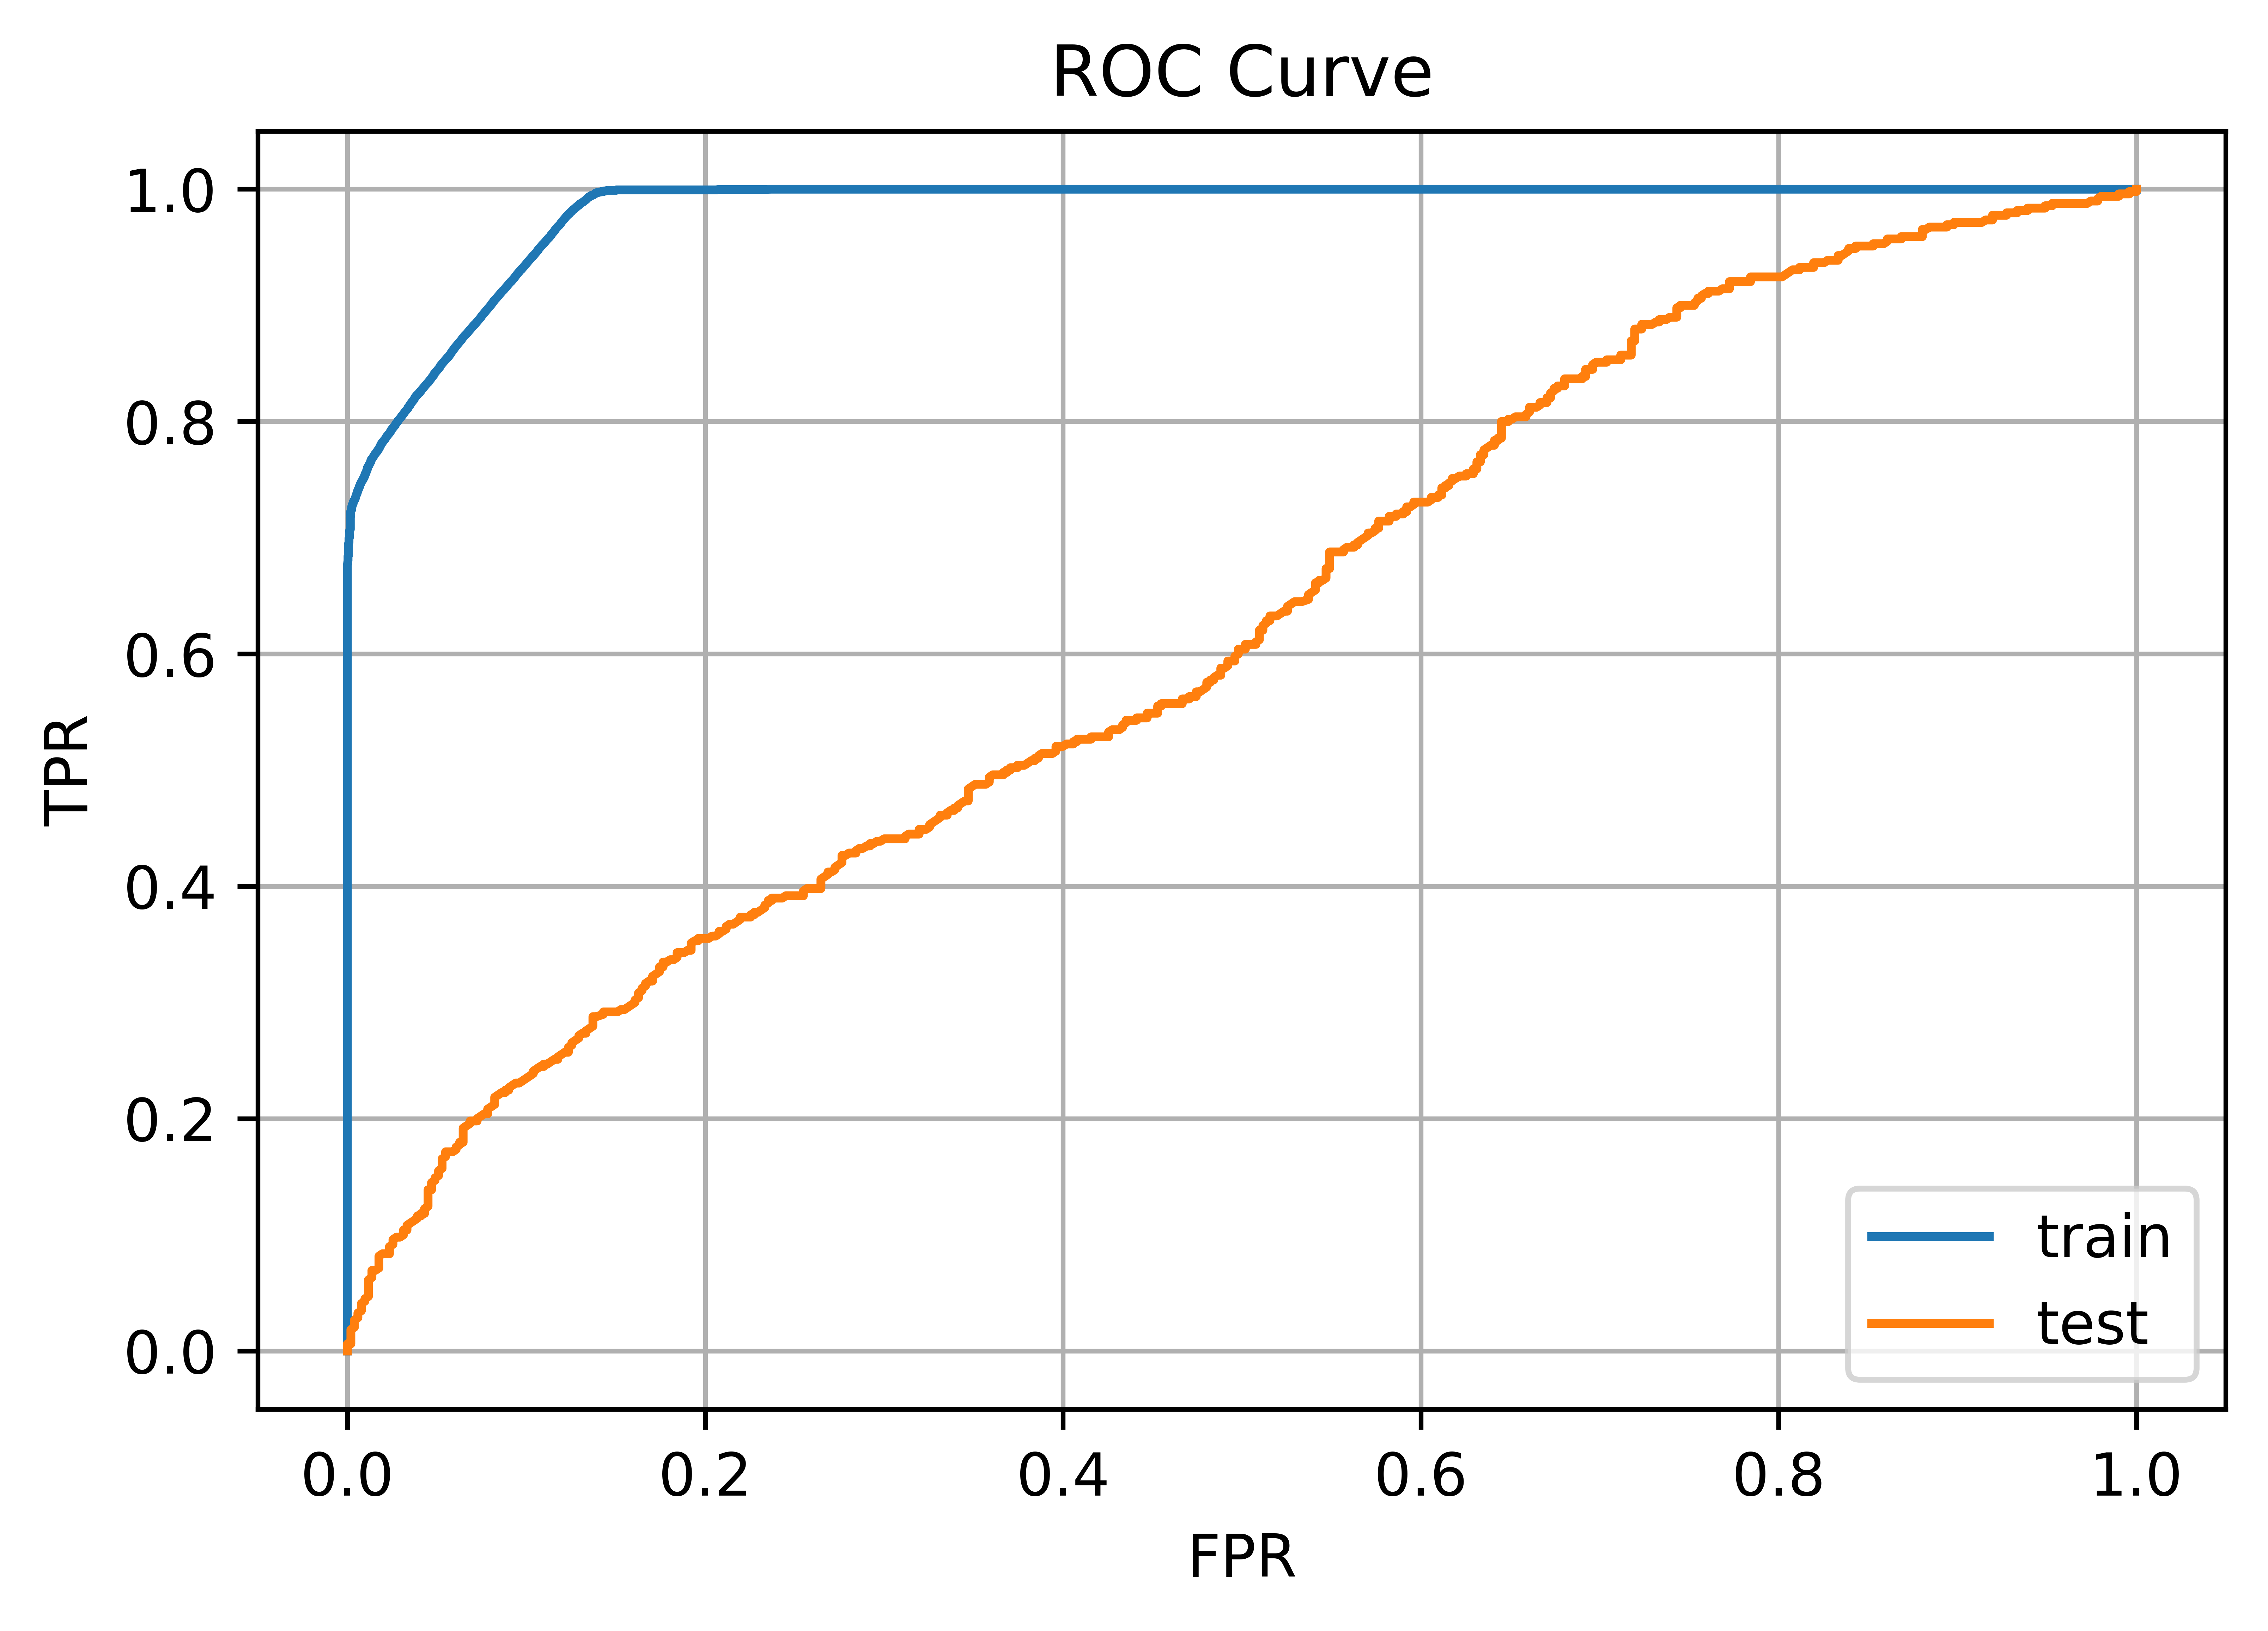

In [ ]:
# Create the roc curve
test_fpr, test_tpr, _ = roc_curve(true_vals, predictions[:,1], pos_label = 1)
train_fpr, train_tpr, _ = roc_curve(train_true_vals, train_predictions[:,1], pos_label = 1)

# Create a dataframe of fpr and tpr to create visual
testRocDf = pd.DataFrame({'fpr': test_fpr, 'tpr': test_tpr, 'data':['test']*len(test_tpr)})
trainRocDf = pd.DataFrame({'fpr': train_fpr, 'tpr': train_tpr, 'data': ['train'] * len(train_tpr)})
rocDf = pd.concat([testRocDf, trainRocDf])
plt.rcParams['figure.dpi'] = 1200
plt.plot(trainRocDf['fpr'], trainRocDf['tpr'],label = 'train')
plt.plot(testRocDf['fpr'], testRocDf['tpr'],label = 'test')
plt.legend()
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')